In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('.')
import utils

In [2]:
def f(x):
    return x * np.cos(np.pi*x)

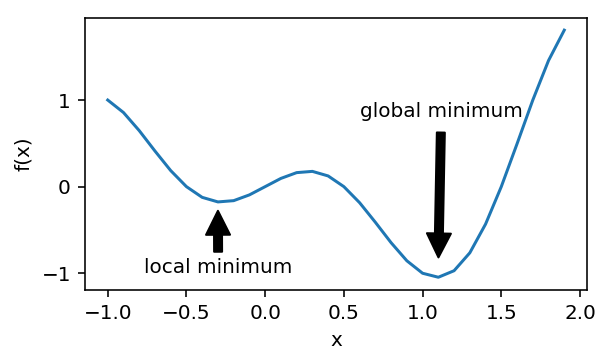

In [15]:
utils.set_fig_size(mpl, (4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig = plt.figure()
subplot = fig.add_subplot(111)
subplot.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0), arrowprops=dict(facecolor='black', shrink=0.05))
subplot.annotate('global minimum', xy=(1.1, -0.9), xytext=(0.6, 0.8), arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

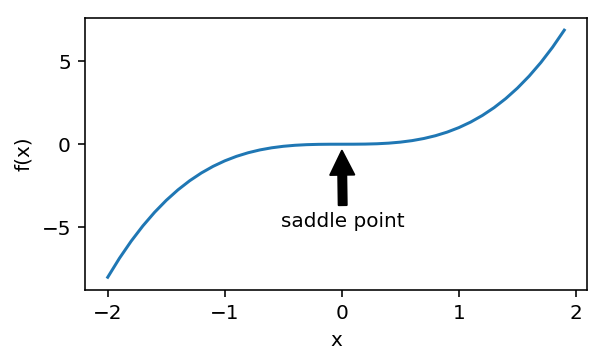

In [25]:
x = np.arange(-2.0, 2.0, 0.1)
fig = plt.figure()
subplt = fig.add_subplot(111)
subplt.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot(x, x**3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [26]:
from mpl_toolkits.mplot3d import Axes3D

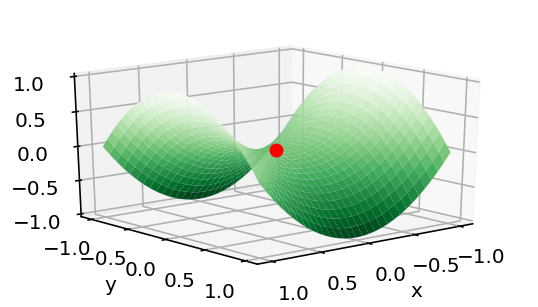

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.mgrid[-1:1:31j, -1:1:31j]
z = x**2 - y**2
ax.plot_surface(x, y, z, **{'rstride':1, 'cstride':1, 'cmap':'Greens_r'})
ax.plot([0], [0], [0], 'ro')
ax.view_init(azim=50, elev=20)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [38]:
# mini-batch SGD
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad/batch_size

In [39]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import nd
import numpy as np
import random
import sys
sys.path.append('..')
import utils

In [40]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)

In [41]:
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    for param in params:
        param.attach_grad()
    return params

def linreg(X, w, b):
    return nd.dot(X, w) + b

def squared_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape))**2/2

def data_iter(batch_size, num_examples, X, y):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield X.take(j), y.take(j)
    

In [46]:
net = linreg
squared_loss = squared_loss
# mini-batch sgd 时，当迭代周期大于2，lr 在每个迭代周期开始时自乘 0.1 做衰减 decay
def optimize(batch_size, lr, num_epochs, log_interval, decay_epoch):
    w, b = init_params()
    y_vals = [squared_loss(net(X, w, b), y).mean().asnumpy()]
    print('batch_size', batch_size)
    for epoch in range(1, num_epochs+1):
        # 学习率自我衰减
        if decay_epoch and epoch > decay_epoch:
            lr *= 0.1
        for batch_i, (features, label) in enumerate(data_iter(batch_size, num_examples, X, y)):
            with autograd.record():
                output = net(features, w, b)
                loss = squared_loss(output, label)
            loss.backward()
            sgd([w, b], lr, batch_size)
            if batch_i*batch_size % log_interval == 0:
                y_vals.append(squared_loss(net(X, w, b), y).mean().asnumpy())
        print('epoch %d, learning rage %f, loss %.4e' %(epoch, lr, y_vals[-1]))
    # 为了便于打印，改变输出形状并转化成numpy数组。
    print('w', w.reshape((1, -1)).asnumpy(), 'b', b.asscalar(), '\n')
    x_vals = np.linspace(0, num_epochs, len(y_vals), endpoint=True)
    utils.semilogy(x_vals, y_vals, 'epoch', 'loss')

In [47]:
optimize(batch_size=2, lr=0.2, num_epochs=3, decay_epoch=2, log_interval=10)

('batch_size', 2)
epoch 1, learning rage 0.200000, loss 5.7228e-05
epoch 2, learning rage 0.200000, loss 5.8437e-05
epoch 3, learning rage 0.020000, loss 4.8656e-05
('w', array([[ 1.9996711 , -3.40064144]], dtype=float32), 'b', 4.2009869, '\n')


AttributeError: 'module' object has no attribute 'semilogy'